In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import talib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization
from sklearn.preprocessing import MinMaxScaler

In [65]:
def Prepare_dataset(df,data_size=500,scale=True,seq_length=5):
    df.dropna(inplace=True,how="all",axis=0)
    df=df.iloc[-data_size:]

    y=df["Close"].shift(-1)
    #X=df.drop(["Adj Close"],1)
    X=df
    
    if scale==True:
        scaler=MinMaxScaler()
        scaler=scaler.fit(np.expand_dims(X,axis=1))
        
        X=scaler.transform(p.expand_dims(X),axis=1)
    
    sma15=X["Close"].transform(lambda x: x.rolling(window=15).mean())
    sma5=X["Close"].transform(lambda x: x.rolling(window=5).mean())
    rsi=talib.RSI(X["Close"])
    mfi=talib.MFI(X["High"],X["Low"],X["Close"],X["Volume"])
    obv=talib.OBV(X["Close"],X["Volume"])
    atr=talib.ATR(X["High"],X["Low"],X["Close"],14)

    X=X.iloc[15:-1,:].copy()
    y=y.iloc[15:-1].copy()

    X["Log return"]=np.log1p(X.Close.pct_change())
    X.loc[:,"SMA 15"]=sma15
    X.loc[:,"SMA 5"]=sma5
    X.loc[:,"RSI"]=rsi
    X.loc[:,"MFI"]=mfi
    X.loc[:,"OBV"]=obv
    X.loc[:,"ATR"]=atr
    
    X.drop("Close",axis=1,inplace=True)
    
    return train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

def LSTM_model(X_train,X_test,y_train,scale=True):
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph() 

    global lstm_model

    if scale==True:     
        x_scaler = MinMaxScaler()
        X_train=x_scaler.fit_transform(X_train)
        X_test=x_scaler.transform(X_test)
        
    x_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
    x_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)
    #np.asarray(y_train).reshape(1,-1)

    lstm_model = Sequential()
    lstm_model.add(LSTM(50,return_sequences=True,stateful=True,activation="swish"))
    lstm_model.add(LSTM(50,return_sequences=False,stateful=True,activation="swish"))
    lstm_model.add(Dense(1,activation="linear"))


    lstm_model.compile(loss="mse",optimizer="nadam",metrics=['accuracy'])
    lstm_model.fit(x_train, np.array(y_train), epochs=1000,verbose=0)
    preds=lstm_model.predict(x_test)

    return preds

In [66]:
min=pd.read_csv(f"../Data/Prices/AAPL_min.csv",index_col=0)
thirt_min=pd.read_csv(f"../Data/Prices/AAPL_thirt_min.csv",index_col=0)
hour=pd.read_csv(f"../Data/Prices/AAPL_hour.csv",index_col=0)
daily=pd.read_csv(f"../Data/Prices/AAPL_daily.csv",index_col=0)
weekly=pd.read_csv(f"../Data/Prices/AAPL_weekly.csv",index_col=0)

datasets={}
datasets["1m"]=Prepare_dataset(min)
datasets["30m"]=Prepare_dataset(thirt_min)
datasets["1h"]=Prepare_dataset(hour)
datasets["D"]=Prepare_dataset(daily)
#datasets["W"]=Prepare_dataset(weekly)

In [64]:
test=LSTM_model(datasets["D"][0],datasets["D"][1],datasets["D"][2])

ValueError: in user code:

    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1008 __call__
        self._maybe_build(inputs)
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:2710 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:596 build
        self.reset_states()
    C:\Users\Norbiez\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:914 reset_states
        raise ValueError('If a RNN is stateful, it needs to know '

    ValueError: If a RNN is stateful, it needs to know its batch size. Specify the batch size of your input tensors: 
    - If using a Sequential model, specify the batch size by passing a `batch_input_shape` argument to your first layer.
    - If using the functional API, specify the batch size by passing a `batch_shape` argument to your Input layer.


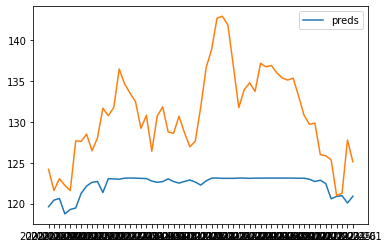

In [22]:
plt.plot(test,label="preds")
plt.plot(datasets['D'][3])
plt.legend()
plt.show()

In [23]:
def prepare_sequences(x_train, y_train, window_length):
    windows = []
    windows_y = []
    for i, sequence in enumerate(x_train):
        len_seq = len(sequence)
        for window_start in range(0, len_seq - window_length + 1):
            window_end = window_start + window_length
            window = sequence[window_start:window_end]
            windows.append(window)
            windows_y.append(y_train[i])
    return np.array(windows), np.array(windows_y)

In [29]:
w,d=prepare_sequences(datasets['D'][0],datasets['D'][2],1)

In [30]:
d.shape

(61,)